# Implementação do Algoritmo Unscented Kalman Filter (UKF)

## Implementação em Python

### Desenvolvimento do Arquivo Teste :

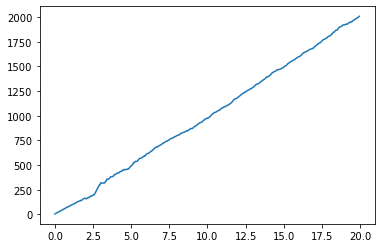

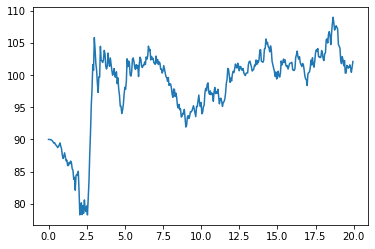

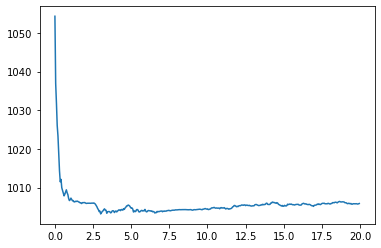

In [3]:

#libraries
import RadarUKF as rf
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from math import sqrt

# Functions for this example
def GetRadar(dt):   
    posp = 0
    while True:
        # Estipulate velocity and altitude
        vel = 100  +  5*np.random.randn()
        alt = 1000 + 10*np.random.randn()
        pos = posp + vel * dt

        v = pos * 0.05 * np.random.randn()
        r = sqrt((pos**2 + alt**2)) + v

        posp = pos
        yield r




#declaring initial Variables
dt = 0.05
t = np.arange(0,20,dt)
Nsamples = len(t)
Xsaved = np.zeros((3, Nsamples))
Zsaved = np.zeros((1, Nsamples))

#Declaring Objects
measure = GetRadar( dt )
UKF = rf.UKF()


for k in range(Nsamples):
    
    # Radius Iteration - (pseudo) random values
    r = next(measure)
    # Measure by UKF
    pos, vel, alt = UKF.UKF(r, dt)

    #store values
    Xsaved[:, k] = pos, vel, alt
    Zsaved[0, k] = r

PosSaved = Xsaved[0, :]
VelSaved = Xsaved[1, :]
AltSaved = Xsaved[2, :]

plot, dx = plt.subplots()
plot, dv = plt.subplots()
plot, ax = plt.subplots()


dx.plot(t, PosSaved, '-', label="Position", markersize=0.5)
dv.plot(t, VelSaved, '-', label="Velocity", markersize=0.5)
ax.plot(t, AltSaved, '-', label="Altitude", markersize=0.5)

plt.show()

### Classe RadarUKF

In [12]:
#libraries used in this example
import numpy as np
from scipy.linalg import inv, cholesky

class RadarUKF(object):
	"""docstring for UKF"""
	def __init__(self):

		self.x = np.array([0,90,1100])
		self.m = self.x.size
		self.n = 1
		self.Q = 0.01 * np.eye(self.m)  # Process noise matrix
		self.R = np.array([100]) # Measurement noise matrix
		self.P = 100*np.eye(self.m)		

		self.kappa = 0
		self.dt = 0


		# Array com Pesos dos Sigma Points
		self.W = self.calc_weight()


	def calc_weight(self):
		size = self.m*2+1
		W = np.full(size, 1./(2*(self.m+self.kappa)))
		W[0] = self.kappa / (self.m + self.kappa)

		return W

	#DONE 
	def SigmaPoints(self): 
            
		#sigmaPts[0] = x
		#sigmaPts[i] = x + U[i]  , with i = 1,2, ..., (M-1)
		#sigmaPts[i] = x - U[i]  , with i = M, M+1, ..., 2M. 
        
		x = self.x
		scal = self.m+self.kappa
		U = cholesky((scal)*self.P)
		Xi = np.zeros((2*self.m+1, self.m))

		Xi[0] = self.x
        
		for k in range(self.m):
			Xi[k+1]   = x + U[k]
			Xi[n+k+1] = x - U[k]
            
		return Xi

	
	def UT(self, sigma, Noise, W = None):
		
		if W == None:
			W = self.W
		xm = np.dot(W, sigma)
	
		

		size, n = sigma.shape
		cov = np.zeros((n,n))
		
		aux = np.zeros((n, n))
		

		for i in range(size):
			Y = sigma[i] - xm
			Y = Y.reshape(n, 1)


			aux = W[i] * np.dot(Y, Y.T)

			cov += aux#gemm_batch			

		cov += Noise
		return xm, cov
		

	def hx(self,x):
		return (x[0]**2 + x[2]**2)**(1/2)

	def UT_Hx(self, sigma):

		size, _ = sigma.shape

		Hxi_pts = np.zeros((size, 1))
		for i in range(size):
			Hxi_pts[i] = self.hx(sigma[i])
	
		return Hxi_pts


	def fx(self, x, dt):
		A = np.eye(3) + dt*np.array([[0, 1, 0],
								      [0, 0, 0],
								      [0, 0, 0]])

		return np.matmul(A, x)

	def UT_Fx(self, Xi, dt):
		size, _ = Xi.shape

		Fxi_pts = np.zeros((size, self.m))
		
		for i in range(size):

			Xi_vector = np.array(Xi[i]).T
			
			Fxi_pts[i] = self.fx(Xi_vector, dt)
	
		return Fxi_pts


	def UKF(self, z, dt):
		
		Xi  = self.SigmaPoints()
		fXi = self.UT_Fx(Xi, dt)
		
		hXi = self.UT_Hx(Xi)
			
		xp, Pp = self.UT(fXi, self.Q)
		zp, Pz = self.UT(hXi, self.R)

		# ===/= Estou aqui (oneAPI)=/===
		
		Pxz = np.zeros((self.m,self.n))

		for i in range(2*self.m+1):
			a = fXi[i] - xp
			b = hXi[i] - zp
			Pxz+= self.W[i]*np.outer(a, b)		
		

		K = np.dot(Pxz, inv(Pz))
		self.x = xp + np.dot(K, (z-zp))
		

		self.P = Pp - np.dot(np.dot(K, Pz),K.T)
		Kpz = np.dot(K,Pz)
		P1 = np.dot(Kpz, K.T)
		P  = Pp - P1
		pos = self.x[0]
		vel = self.x[1]
		alt = self.x[2]
		


		return pos, vel, alt





# DPC++ implementation

In [27]:
%%writefile TestRadarUKF.cpp
#include <iostream>

#include <vector>
using std::vector; 

#include <fstream>
using std::ifstream; 
using std::ofstream; 


#include <stdlib.h>


#include <string>
using std::stof;
using std::string;

#include <limits>
#include <random>

#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"
namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;

#include "RadarUKF.h"



//Function Prototype
double *GetRadar(int Nsamples,double dt, int seed);



int main(){
    //create file : TestRadarUKF.csv
    ofstream myfile("TestRadarUKF.csv");
    myfile << "time,Position,Velocity,Altitude\n";
    auto async_handler = [](sycl::exception_list exceptions) {
        for (std::exception_ptr const &e : exceptions) {
            try {
                rethrow_exception(e);
            }
            catch (sycl::exception const &e) {
                std::cout << "Caught asynchronous SYCL exception: " << e.what() << std::endl;
            }
        }
    };
    
    try {
        
         
        //About Accelerator Device & Queue
        sycl::device device = sycl::device(sycl::default_selector());
        std::cout << "Device: " << device.get_info<sycl::info::device::name>() << "\n";
        sycl::queue queue(device, async_handler);
        vector<sycl::event> event_list;
        
        
        
        //Declare example variables, lists and Kalman Object
        double dt = 0.05;
        
        
        const int Nsamples = 400;
        double t[Nsamples];
        const int seed = 777; 
        double *Radius = GetRadar(Nsamples, dt, seed);
          
        //#set initial matrix:
        auto *Q = sycl::malloc_shared<double>(3 * 3, queue);
        eye(Q, 3, 0.01); 
        
        auto *R = sycl::malloc_shared<double>(1 * 1, queue);
        R[0] = 100.0;
        
        auto *x = sycl::malloc_shared<double>(3 * 1, queue);
        x[0] = 0.0; x[1] = 90.0; x[2]  = 1100.0; 
        
        auto *P = sycl::malloc_shared<double>(3 * 3, queue);
        eye(P, 3, 100.0);
    
        auto *z = sycl::malloc_shared<double>(1 * 1, queue);
        
        // #Set RadarUKF objects 
        
        RadarUKF *Rf = new RadarUKF();
        Rf->setTransitionCovMatrix(Q);
        Rf->setMeasureCovMatrix(R);
        Rf->setErrorCovMatrix(P);
        Rf->setSttVariable(x);
        
        auto *PosSaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *VelSaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *AltSaved = sycl::malloc_shared<double>(Nsamples, queue);
        
        if (!PosSaved || !VelSaved || !AltSaved) {
            std::cerr << "Could not allocate memory for vectors." << std::endl;
            exit(1);
        }
        
        double pos, alt, vel; 
        for (int i = 0; i < Nsamples ; i++){  
                
            z[0] = Radius[i];

            t[i] = dt*i;
            
            
            
            //Update then save.
            
            Rf->UKF(z, dt);
            pos = Rf->getResult(0);
            alt = Rf->getResult(1);
            vel = Rf->getResult(2);
            
            
            //#then store on arrays
            
            PosSaved[i] = pos; 
            AltSaved[i] = alt; 
            VelSaved[i] = vel; 
            
            
            //#Save the results below in myfile. 
            myfile << t[i] <<", "<< pos << ", " << vel << ", " << alt <<'\n';
            
        }
        myfile.close();
        free(PosSaved, queue);
        free(VelSaved, queue);
        free(AltSaved, queue);
        
        //kalman->end_task();

    } catch (const exception &e) {
        std::cerr << "An exception occurred: "
                  << e.what() << std::endl;
        exit(1);
    }
}

double *GetRadar(int Nsamples,double dt, int seed){
	int posp = 0;
	int i = 0; 

	std::default_random_engine generator;
	generator.seed(seed);
	std::normal_distribution<double> distribution(0.0, 1.0);

	double *radar = new double[Nsamples];

	double vel, v, r, alt, pos;
	while (i < Nsamples){ 
        
		vel = 100  +  5*distribution(generator);
        alt = 1000 + 10*distribution(generator);
        pos = posp + vel*dt;

        v = pos *.05 * distribution(generator);
        r = sqrt(pos*pos + alt*alt) +v;
        radar[i++] = r;
        posp = pos;
    
	}

	return radar;
}




Overwriting TestRadarUKF.cpp


# RadarUKF Class Implementation (DPC++)

In [28]:
%%writefile RadarUKF.h


#include <iostream> 


#include <cmath>

#include <stdlib.h>

#include <limits>


#include <CL/sycl.hpp>
using namespace sycl;

#include "oneapi/mkl.hpp"

#include <algorithm> 


namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;


auto nontransM = oneapi::mkl::transpose::nontrans;
auto    transM = oneapi::mkl::transpose::trans;
auto    upperM = oneapi::mkl::uplo::upper;
auto    lowerM = oneapi::mkl::uplo::lower;
                    
 

void display(double *A, int l, int c){ 
	for(int i = 0; i< l;i++){
		for( int j =0;j<c;j++)
			std::cout << A[c*i+j] << " ";
		std::cout << std::endl;
	}	

}

void zero(double* A, int l, int m){
	for(int i =0; i < l*m; i++){
			A[i] = 0.0;
	}
}

void eye(double* A, int l, double val){
	for(int i =0; i < l; i++){
		for(int j=0; j<l; j++){
			if(i == j) A[j+i*l] = val;
			else A[j+i*l] = 0.0;
		}
	}
}

double* matrix2vector(sycl::queue &queue, double* A, int m, int n, int pos){
    
    double *y = sycl::malloc_shared<double>(n, queue);
    for(int i = 0; i < n; i++)
        y[i] = A[n*pos + i];

    return y;
}

double* NullVector(sycl::queue &queue, int m, int n = 1, int val = 0){
    
    double *y = sycl::malloc_shared<double>(m*n, queue);
    for(int i = 0; i < m*n; i++)
        y[i] = val;

    return y;
}

       
// # hx function definition
double hx(double x1, double x2){
    
    return sqrt(x1*x1 + x2*x2);
}


void inv(sycl::queue &queue, double *A, int64_t N) {
    sycl::event getr_task[2];
    vector<sycl::event> event_list;

    double scratch_size = lapack::getrf_scratchpad_size<double>(queue, N, N, N);
    double *scratchpad = sycl::malloc_shared<double>(scratch_size+1, queue);

    auto *IPIV = sycl::malloc_shared<int64_t>(N*N, queue);
    
    getr_task[0] = lapack::getrf(queue, N, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[0].wait();
    getr_task[1] = lapack::getri(queue, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[1].wait();
    
    free(IPIV, queue);
}
    
double *cholesky(sycl::queue &queue, double *L, int64_t nb,double alpha){
/* # ====================
    
    #U    -> matriz Input
    #nb   -> numero de linhas do bloco U
    #alpha-> multiplicador escalar na função de Cholesky
    
   # ====================*/
    
    // # Make a copy of P (P must remain unchanged)
    double *U = sycl::malloc_shared<double>(nb*nb, queue);
    zero(U,nb,nb);
    
    auto copy_L = blas::row_major::copy(queue, nb*nb, 
                                        L, 1, U, 1);
    copy_L.wait();
    
    std::int64_t scratchpad_size = lapack::potrf_scratchpad_size<double>(queue, lowerM, nb, nb);
    double *scratchpad = sycl::malloc_shared<double>(scratchpad_size, queue);
    
    
    auto event1 = blas::scal(queue, nb*nb, alpha, U, 1.0);
    event1.wait_and_throw();
    
    
    auto event2 = lapack::potrf(queue, lowerM, nb, U, nb, scratchpad, scratchpad_size );
    event2.wait_and_throw();
    
    for(int i = 0; i<nb; i++){
        for(int j = 0; j<nb;j++){
            if(i>j) U[i*nb+j] = 0;
        }
    }
    
    free(scratchpad, queue);
    
    return U;
}




class RadarUKF{
public: 


    
    //# Setters member-functions 
    void setSttVariable(double * xset);
    void setTransitionCovMatrix(double * Qset);
    void setMeasureCovMatrix(double * Rset);
    void setErrorCovMatrix(double * Pset);
    
    //# getter memb. functions
    double getResult( int );
        
    
    //# prediction functions
    double *calc_weights();
    void SigmaPoints(double**);
    
    double *fx(double *,double dt);
    double *hx(double *);
    
    
    void UT_Hx(double **Hx_pts, double **sigma);
    void UT_Fx(double **Fx_pts, double **sigma, double dt);
    void UT(const double **sigma, int n, double* Noise, double* xm, double* cov);
        
    
    //# Update step
    void UKF( double *,double);
    
    void end_task();
private: 
    sycl::queue queue;
    
    //# Matrix Pointers
    double *Q;
    double *R;
    double *x;
    double *P; 
    double *z;
    
    
    //#Config. values
    double alpha = 1.0; 
    double beta  = 0.0;
    const int M = 3; 
    const int L = 1;

    const int WSize = M*2+1; //## Size of SigmaPoints Array
    double kappa = 0; 
    
    
    
    
    //# Sigma Points Allocation
    double *sigma_pts = sycl::malloc_shared<double>(7 * 3, queue);
    
    
    //# Weights to sigma_pts
    double *W = calc_weights();
    
    
    //# Intermediary values to calculus
    
    //#  fx function
    
    
    //# Sigma Point Arrays
    double **Xi  = sycl::malloc_shared<double*>(WSize, queue);
    double **fXi = sycl::malloc_shared<double*>(WSize, queue);
    double **hXi = sycl::malloc_shared<double*>(WSize, queue);
    

    //# fx_sigma Points function allocations: 
    
    

    
    //# calc_UT function allocations: 
    //#double *xm     = sycl::malloc_shared<double>(M * 1, queue);
    
    
    
    
    double *xcov = sycl::malloc_shared<double>(M * M, queue);
    
    
    
    
    
    //# UKF function allocations:
    double *zp    = sycl::malloc_shared<double>(L * L, queue);
    double *xp    = sycl::malloc_shared<double>(M * L, queue);
    
    double *Pz    = sycl::malloc_shared<double>(M * L, queue);
    double *Pxz   = sycl::malloc_shared<double>(M * L, queue);
    
    // # Array's Matrix
    

    
    
    double *KPz   = sycl::malloc_shared<double>(M * M, queue);
    double *Pp    = sycl::malloc_shared<double>(M * M, queue);
    
    double *K     = sycl::malloc_shared<double>(M * M, queue);
    double *AP    = sycl::malloc_shared<double>(M * M, queue);   
    
    
};

    //#setters functions
void RadarUKF::setSttVariable(double * xset){
    x = xset;
}

void RadarUKF::setTransitionCovMatrix(double * Qset){
    Q = Qset;
}

void RadarUKF::setMeasureCovMatrix(double * Rset){
    R = Rset;
}

void RadarUKF::setErrorCovMatrix(double * Pset){
    P = Pset;
}
        
    //# getter function
double RadarUKF::getResult(int l){
    return x[l];
}
    


//Weight Sigma-Points Calculus

double *RadarUKF::calc_weights(){
    int den = this->M + this->kappa;
    int size = this->M*2+1;
    double *W_set = sycl::malloc_shared<double>(size, queue);
    
    //set all values in W = 1/(2M+kappa)
    auto e1 = queue.parallel_for(sycl::range<1>(size-1), [=](id<1> i){W_set[i+1] = 1./(2*den);});
    e1.wait();             
    // Except W[0]
    W_set[0] = this->kappa / den;
    
    return W_set; 
}
    
double *RadarUKF::fx(double *x_in, double dt){
    
    double *fx_vec = sycl::malloc_shared<double>(M * 1, queue);
    double *A = sycl::malloc_shared<double>(M * M, queue);
    
    // # to-do:improve by using the Xi pointers and A Matrix (gemm_batch)
    
    
    // # set A matrix
    eye(A, M, 1.0);
    A[1] = dt;
    
    
    // # Fx = A*Xi
    auto fx_event = blas::row_major::gemm(queue, nontransM, nontransM,
                                          M, L, M, 
                                          1.0, A, M, 
                                          x_in, L, beta, fx_vec, L);
    fx_event.wait();
    free(A, queue);
    
    return fx_vec;
}
    
double *RadarUKF::hx(double *x_in){
    
    double x1 = x_in[0]; 
    double x2 = x_in[2]; 
    
    double *hx_vec = sycl::malloc_shared<double>(1 * 1, queue);
    hx_vec[0] = sqrt(x1*x1 + x2*x2);
    
    return hx_vec;
}
    

void RadarUKF::UT_Hx(double **Hx_pts, double **sigma_h){
    
    
    //## to-do: Parallel-for(?)

    for(int i = 0; i < WSize; i++){
        Hx_pts[i] = hx(sigma_h[i]);

    }
    
}

void RadarUKF::UT_Fx(double **Fx_pts, double **sigma, double dt){

    
    //## to-do: Parallel-for(?)
    for(int i=0; i< WSize;i++){
        Fx_pts[i] = fx(sigma[i], dt);

    }
}
void RadarUKF::SigmaPoints(double **SigmaPts){
    
    //# Declaring initial variables
    double scal = M + this->kappa;   
    
    
    // #Cholesky decomposition: fix-me ?
    auto U = cholesky(queue, P, M, scal);
    
    
    double **arr_1 = sycl::malloc_shared<double*>(WSize*2, queue);
    double **arr_2 = sycl::malloc_shared<double*>(WSize*2, queue);

    
    
    //#fix: copy_batch?
    for(int i = 0; i < WSize; i++){
        SigmaPts[i] = NullVector(queue, M);
        arr_1[WSize+i] = x;
        arr_2[i] = SigmaPts[i];
        arr_2[WSize+i] = SigmaPts[i];
    }
        
    
    //# Decompose U matrix in M vectors, to use in axpy_batch
    arr_1[0] = NullVector(queue, M);
    for(int i=0; i<M; i++){
        arr_1[i+1] = matrix2vector(queue, U, M, M, i);
        arr_1[M+i+1] = matrix2vector(queue, U, M, M, i);        
    }
  
    
    //## axpy_batch application: 
    //# sigmaPts[0] = x
    //# sigmaPts[i] = x +  1 *U[i]  , with i = 1,2, ..., (M-1)
    //# sigmaPts[i] = x +(-1)*U[i]  , with i = M, M+1, ..., 2M. 

    //# set data to axpy_batch: cov = cov+scal(W[i])*(Y x Y.t)
    //# value function axpy_batch
    const int GRP = 4;                                       //# Total de grupos
    const std::int64_t n_axpy[GRP] = {M, M, M, M};           //# Total de elementos por operação
    double a_axpy[GRP]             = {0.0, 1.0, -1.0, 1.0};  //# Escalar da operação
    const std::int64_t incr[GRP]   = {1, 1, 1, 1};           //# Distancia entre os elementos
    std::int64_t sz_axpy[GRP]      = {1, M, M, WSize};       //# Qtd. soma/subtracao por grupo
        
    
    auto sigma_ev = blas::axpy_batch(queue, n_axpy, a_axpy, 
                                     (const double **) arr_1, incr,
                                     arr_2, incr, 
                                     GRP, sz_axpy);
 
    sigma_ev.wait();            
    
    free(arr_1,queue);
    free(arr_2,queue);
}
    
void RadarUKF::UT(const double **sigma, int n, double* Noise, double* xm, double* xcov){
    
    // ## Set xm: xm += scal(W[i])*sigma[i]   ,  with i=0, 1, ..., WSize.
    // #Variables to axpy_batch:
    double **xm_arr = sycl::malloc_shared<double*>(WSize, queue);
    
    const int xm_grp = WSize; 
    std::int64_t n_scal[xm_grp] ;
    double a_scal[xm_grp];
    std::int64_t incr_scal[xm_grp];
    std::int64_t sz_scal[xm_grp];
    
    
    //#xm = NullVector(queue, n);
    
    for(int i=0; i< WSize; i++){
        n_scal[i]    = n;
        a_scal[i]    = W[i];
        incr_scal[i] = 1; 
        sz_scal[i]   = 1;
        xm_arr[i] = xm;
    }

    // # xm = xm + scal(W[i])*sigma[i]
    auto scal_event = blas::axpy_batch(queue, n_scal, a_scal, 
                                      sigma, incr_scal,
                                      xm_arr, incr_scal, 
                                      xm_grp, sz_scal);
    scal_event.wait();

    
    //# fix me: tamanho de Y
    std::int64_t copy_sz[1]   = {n};
    std::int64_t copy_incr[1] = {1};
    std::int64_t copy_grp[1]  = {WSize};
    
    double **Y = sycl::malloc_shared<double*>(WSize, queue);

    //# Fill Y vector with NullVectors
    for(int i = 0; i < WSize;i++){
        Y[i]      = NullVector(queue, n);
    }
    
    auto copy_event = blas::row_major::copy_batch(queue, copy_sz,
                                                  sigma, copy_incr,
                                                  Y, copy_incr, 1, copy_grp);
    copy_event.wait();
    
    
     //### 1.0) Y[i] = - xm + Y[i]  == -xm + sigma[i] 
    // ## Initial conditions for axpy_batch: Y[i] = sigma[i] - xm    
    
    
    const std::int64_t s_axpy[] = {n};
    double a_axpy[]             = {-1.0}; 
    const std::int64_t s_incr[] = {1};
    std::int64_t sz_axpy[]      = {WSize};
    

    auto sum_event = blas::axpy_batch(queue, s_axpy, a_axpy, 
                                      (const double **) xm_arr, s_incr,
                                      Y, s_incr, 
                                      1, sz_axpy);
    sum_event.wait(); 
    

    
    //## Covariation Calculus: cov = Noise + sum(W[i] * (Y[i] x Y[i].T),     with i = 0, 1, ..., n. 
    //# 1.1)  cov = cov+scal(W[i])*(Y x Y.t) 
    
    //# set data to gemm_batch: cov = cov+scal(W[i])*(Y x Y.t)      
    //# value function gemm_batch
    double **cov_arr = sycl::malloc_shared<double*>(WSize, queue); 
    
    const int cov_grp = WSize; 
    oneapi::mkl::transpose transA[cov_grp];
    oneapi::mkl::transpose transB[cov_grp];
    
    std::int64_t m_lst[cov_grp];
    std::int64_t k_lst[cov_grp];
    
    std::int64_t lda_lst[cov_grp];
    std::int64_t ldc_lst[cov_grp] ;
    
    double a_lst[cov_grp];
    double b_lst[cov_grp];
    
    std::int64_t grp_sz[cov_grp];
    
    
    for(int it=0; it < cov_grp; it++){
        transA[it]  = nontransM;
        transB[it]  = transM;
        m_lst[it]   = n; 
        k_lst[it]   = 1; 
        lda_lst[it] = 1;
        ldc_lst[it] = n;
        a_lst[it]   = W[it]; 
        b_lst[it]   = 1.0;
        grp_sz[it]  = 1; 
        // # set C array with cov adress
        cov_arr[it]  = xcov;
        
    }

    
    // # cov = cov + scalar(W[i]) *(Y[i] x Y[i].T)
    auto gemm_event = blas::row_major::gemm_batch(queue,
                                                  transA, transB,
                                                  m_lst, m_lst, k_lst, a_lst, 
                                                  (const double **) Y, lda_lst, 
                                                  (const double **) Y, lda_lst, 
                                                  b_lst, cov_arr, ldc_lst, 
                                                  cov_grp, grp_sz);
    
    gemm_event.wait();
    
    
    
    //# 1.2) cov = cov + Noise

    
    
    auto sum_event2 = blas::axpy(queue, n*n, alpha, Noise , 1.0, xcov, 1.0);
    sum_event2.wait(); 
    
    
    // # Free memory for auxiliary pointers.
    free(cov_arr, queue);
    free(xm_arr, queue);
    free(Y, queue);
}

void RadarUKF::UKF(double *z, double dt){
    
    
    SigmaPoints(Xi);
    
    UT_Fx(fXi, Xi, dt);
    UT_Hx(hXi, Xi);  
    
    zero(xp, M, L);
    zero(Pp,M,M);
    UT((const double **)fXi, M, Q, xp, Pp);
    
    zero(zp, L, L);
    zero(Pz, L, L);
    UT((const double **)hXi, L, R, zp, Pz);
    
    // ### Pxz = scal(W[i]) * ( {fXi[i]- xp}x{hXi[i]- zp}.T),    with i = 0, 1, ...., n.  
    // ## 1.0) Auxilar Vectors:
    // # a[i] = fXi[i] - xp
    // # b[i] = hXi[i] - zp
    
    double **a       = sycl::malloc_shared<double*>(WSize, queue);
    double **b       = sycl::malloc_shared<double*>(WSize, queue);
    double **xp_arr  = sycl::malloc_shared<double*>(WSize, queue);
    double **zp_arr  = sycl::malloc_shared<double*>(WSize, queue);
    
    double **Pxz_arr = sycl::malloc_shared<double*>(WSize, queue);
    double *Pz_copy  = sycl::malloc_shared<double>(M * L, queue);
    
    const int GRP = 1; 
    const std::int64_t fxi_axpy[GRP] = {M};
    const std::int64_t hxi_axpy[GRP] = {L};
    double a_axpy[GRP] = {-1.0};
    
    const std::int64_t incr[GRP] = {1};
    
    std::int64_t sz_axpy[GRP] = {WSize};
    
    
    for(int it=0; it < WSize; it++){
        xp_arr[it] = xp;
        zp_arr[it] = zp;
    }

    // # fXi[i] = (-)xp + fXi[i]
    auto ev1 = blas::axpy_batch(queue, fxi_axpy, a_axpy, 
                                      (const double **) xp_arr, incr,
                                      fXi, incr, 
                                      GRP, sz_axpy);
    ev1.wait();  
    
    // # hXi[i] = (-)zp + hXi[i]
    auto ev2 = blas::axpy_batch(queue, hxi_axpy, a_axpy, 
                                      (const double **) zp_arr, incr,
                                      hXi, incr, 
                                      GRP, sz_axpy);
    ev2.wait();  
    

    // ## 1.1) outer product and scalar: W[i] * ({a[i]} x {b[i]}.T)
    
    
    //# Definitions to gemm_batch: Pxz
    const int grp_Pxz = WSize; 
    oneapi::mkl::transpose transA[grp_Pxz];
    oneapi::mkl::transpose transB[grp_Pxz];
    std::int64_t m_lst[grp_Pxz];
    std::int64_t k_lst[grp_Pxz];
    std::int64_t lda_lst[grp_Pxz];
    std::int64_t ldc_lst[grp_Pxz];
    double a_lst[grp_Pxz];
    double b_lst[grp_Pxz];
    std::int64_t grp_sz[grp_Pxz];
    
    // # Array pointer to Pxz
    
    zero(Pxz, M, M); 

    
    for(int it=0; it < WSize; it++){
        transA[it]  = nontransM;
        transB[it]  = nontransM;
        m_lst[it]   = M;
        k_lst[it]   = 1; 
        lda_lst[it] = 1;
        ldc_lst[it] = M;
        a_lst[it]   = W[it];
        b_lst[it]   = 1.0;
        grp_sz[it]  = 1; 
        
        // # set Pxz_arr
        Pxz_arr[it]  = Pxz;
    }
    
    

    
    auto Pxz_event = blas::row_major::gemm_batch(queue,
                                                 transA, transB,
                                                 m_lst, k_lst, k_lst, a_lst,
                                                 (const double **) fXi, lda_lst, 
                                                 (const double **) hXi, lda_lst, 
                                                 b_lst, Pxz_arr, lda_lst, 
                                                 grp_Pxz, grp_sz);
    Pxz_event.wait();
      
    

    
    
    //## ====================================================== Aqui para baixo, esta OK ===================================================================
    //## K  = Pxz * inv(Pz)
    
    // # Pz = inv(Pz)
    // # OBS: make a copy of Pz, will be used on P calculus
    auto Pz_event = blas::row_major::copy(queue, M*L, 
                          Pz, 1, Pz_copy, 1);
    Pz_event.wait();
    inv(queue, Pz, L);
    
    
    // # K = Pxz * Pz
    auto K_event = blas::row_major::gemm(queue, nontransM, nontransM, M, L, L, alpha, Pxz, L, Pz, L, beta, K, L);
    K_event.wait();
    
    //## x = xp + K * (z-zp)
    // # z = z-zp
    auto zzp_event = blas::axpy(queue, L*L, -alpha, zp, 1.0, z, 1.0);
    zzp_event.wait();

    // # x = K*z -> K*(z-zp)
    auto Kz_event = blas::row_major::gemm(queue, nontransM, nontransM, M, L, L, alpha, K, L, z, L, beta, x, L);
    Kz_event.wait(); 
    
    // # x = xp + x
    auto x_event = blas::axpy(queue, M*L, alpha, xp, 1.0, x, 1.0);
    x_event.wait();
    
    
    //## P = Pp - K*(cp_Pz)*K_t
    // # KPz = K*Pz
    auto KPz_event = blas::row_major::gemm(queue, nontransM, nontransM,
                                           M, L, L,
                                           alpha, K, L,
                                           Pz_copy, L, beta,
                                           KPz, L);
    KPz_event.wait();
    zero(P,M,M);
    // # P = (-)KPz*K_t
    auto P1_event = blas::row_major::gemm(queue, nontransM, transM,
                                           M, M, L,
                                           -alpha, KPz, L,
                                           K, L, beta,
                                           P, M);
    P1_event.wait();
        
    // # P = Pp+(-)P
    auto P2_event = blas::axpy(queue, M*M, alpha, Pp, 1.0, P, 1.0);
    P2_event.wait();
    //# End calculus here, then its necessary to acess it by GetResult, 
    //# which is obtained by the matrix X(nRow x nCol).  
    
        
}

/*
void RadarUKF::~RadarUKF(){
    free(A, queue);
    free(H, queue);
    free(Q, queue);
    free(R, queue);
    free(x, queue);
    free(P, queue);
    free(z, queue);

    free(xp, queue);
    free(Pp, queue);
    free(K, queue);
    free(AP, queue);
    free(Kz, queue);
    
}
*/



Overwriting RadarUKF.h


# CPU execution

dpcpp TestRadarUKF.cpp -o TestRadarUKF -DMKL_ILP64  -I"/glob/development-tools/versions/oneapi/2022.1.2/oneapi/mkl/2022.0.2/include" -fsycl-device-code-split=per_kernel -L/glob/development-tools/versions/oneapi/2022.1.2/oneapi/mkl/2022.0.2/lib/intel64 -lmkl_sycl -lmkl_intel_ilp64 -lmkl_sequential -lmkl_core -lsycl -lOpenCL -lpthread -lm -ldl
./TestRadarUKF
Device: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz


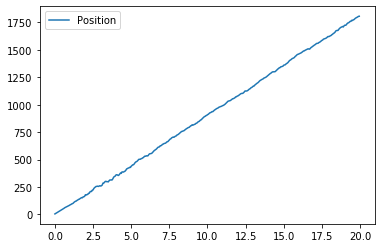

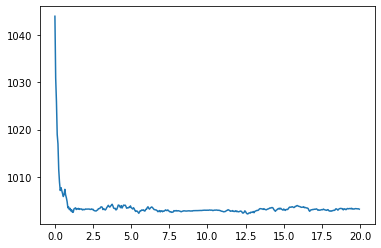

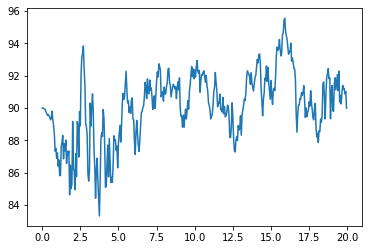

In [29]:
! make 
! mv TestRadarUKF.csv TestRadarUKF_CPU.csv
import matplotlib.pyplot as plt
import pandas as pd


def plot_results(filename):
    df = pd.read_csv(filename)
    
    plot_1, ax = plt.subplots()
    plot_2, ay = plt.subplots()
    plot_3, az = plt.subplots()

    ax.plot(df.time.to_list(), df.Position.to_list(), '-', label="Position")
    ay.plot(df.time.to_list(), df.Velocity.to_list(), '-', label="Velocity")
    az.plot(df.time.to_list(), df.Altitude.to_list(), '-', label="Altitude")
    
    #ax.set(title="Velocity Label", xlabel="Time [sec]", ylabel="Velocity [M/s]")
    #ax.set(title="Position Label", xlabel="Horizontal [Pixels]", ylabel="Vertical [Pixels]")
    ax.legend()

plot_results('TestRadarUKF_CPU.csv')


# GPU execution

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
1863777.v-qsvr-1           ...ub-singleuser u114416         00:00:57 R jupyterhub     
1863784.v-qsvr-1           build_run.sh     u114416         00:02:21 R batch          
1863799.v-qsvr-1           build_run.sh     u114416         00:01:35 R batch          
1863800.v-qsvr-1           build_run.sh     u114416                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (build_run.sh.o1863800)



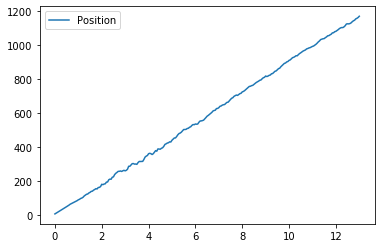

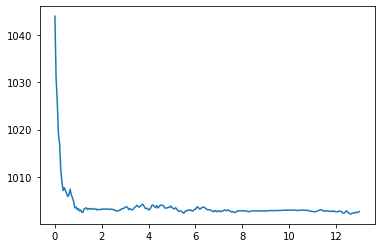

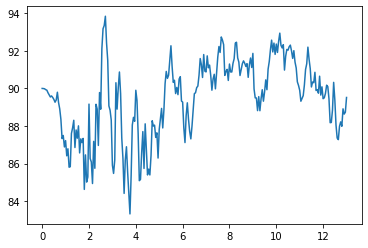

In [32]:
! chmod 755 q; chmod 755 build_run.sh; if [ -x "$(command -v qsub)" ]; then ./q build_run.sh; else ./build_run.sh; fi
! mv TestRadarUKF.csv TestRadarUKF_GPU.csv

plot_results('TestRadarUKF_GPU.csv')